# Advanced Certification in AIML
## A Program by IIIT-H and TalentSprint

The objective of this experiment is to understand regularization.

While our loss function allows us to determine how well (or poorly) our set of parameters (i.e., weight matrix, and bias vector) are performing on a given classification task, the loss function itself does not take into account how the weight matrix “looks”. This brings us to the following questions.  How do we go about choosing a set of parameters that will help ensure our model generalize well? Or at the very least, lessen the affects of overfitting?

The answer is <b>regularization.</b>

This notebook is divided into two parts. In the first part we will observe the behaviour of the weight space after adding adding a regularization term while in the second part, we will use some property of the learnt weight space to remove redundant connections.



#### Keywords

* L1 Regularization
* Pruning
* Batchnorm

#### Expected time to complete the experiment is : 90min

### Setup Steps

In [0]:
#@title Please enter your registration id to start: (e.g. P181900101) { run: "auto", display-mode: "form" }
Id = "P19A06E_test" #@param {type:"string"}


In [0]:
#@title Please enter your password (normally your phone number) to continue: { run: "auto", display-mode: "form" }
password = "981234567" #@param {type:"string"}


In [3]:
#@title Run this cell to complete the setup for this Notebook

from IPython import get_ipython
ipython = get_ipython()
  
notebook="BLR_M3W13_SAT_EXP_1" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    ipython.magic("sx pip3 install torch")
    ipython.magic("sx pip3 install torchvision")
    print ("Setup completed successfully")
    return

def submit_notebook():
    
    ipython.magic("notebook -e "+ notebook + ".ipynb")
    
    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:        
        print(r["err"])
        return None        
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getComplexity() and getAdditional() and getConcepts():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional, 
              "concepts" : Concepts, "record_id" : submission_id, 
              "id" : Id, "file_hash" : file_hash, "notebook" : notebook}

      r = requests.post(url, data = data)
      print("Your submission is successful.")
      print("Ref Id:", submission_id)
      print("Date of submission: ", datetime.datetime.now().date().strftime("%d %b %Y"))
      print("Time of submission: ", datetime.datetime.now().time().strftime("%H:%M:%S"))
      print("View your submissions: https://iiith-aiml.talentsprint.com/notebook_submissions")
      print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
      return submission_id
    else: submission_id
    

def getAdditional():
  try:
    if Additional: return Additional      
    else: raise NameError('')
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None
  
def getConcepts():
  try:
    return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None

def getId():
  try: 
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup 
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
  
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


Let us begin by our regular import statements.

In [0]:
import numpy as np
import torch 
import torchvision
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
%matplotlib inline
import matplotlib.pyplot as plt

### Hyperparameters to be used

In [0]:
num_epochs = 5
batch_size = 100
learning_rate = 0.001
use_reg = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Downloading the MNIST Dataset

In [0]:
train_dataset = dsets.MNIST(root='../data/',
                            train=True, 
                            transform=transforms.ToTensor(),
                            download=True)

test_dataset = dsets.MNIST(root='../data',
                           train=False, 
                           transform=transforms.ToTensor())

### Dataloader

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

### Defining the network

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc1 = nn.Linear(7*7*32, 300)
        self.fc2 = nn.Linear(300, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

<b>The below function is called to reinitialize the weights of the network and define the required loss criterion and the optimizer.</b> 

In [0]:
def reset_model():
    net = Net()
    net = net.to(device)

    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    return net,criterion,optimizer

### L1 Regularization

Here, we define a L1 Regularizer and add it to our loss function. The L1 Regularization term basically adds a penalty, equivalent to the absolute value of the magnitude of the weights. This ensures that the magnitude of the weights do not become too high.

We have seen in the previous lectures that adding the L1 regularizer ensures sparsity. This is important becuase our ultimate aim is to prune connections from our network. That would mean we should try to make as many weights extremely close to 0 as possible. Thus, adding this penalty term ensures sparsity. The L1 Regularizer is also known as Lass Regression and it can be defined as follows:

$$P=\lambda*\sum_{i=1}^{n}|\theta_{i}-0|$$

In [0]:
def l1_regularizer(net, loss, beta):
    l1_crit = nn.L1Loss(size_average=False)
    reg_loss = 0
    for param in net.parameters():
        target = (torch.FloatTensor(param.size()).zero_()).to(device)
        reg_loss += l1_crit(param, target)
        
    loss += beta * reg_loss
    return loss

### Initializing the model

In [0]:
net, criterion, optimizer = reset_model()

### Defining the training function

In [0]:
# Train the Model

def training(net, reset = True):
    if reset == True:
        net, criterion, optimizer = reset_model()
    else:
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    net.train()
    for epoch in range(num_epochs):
        total_loss = 0
        accuracy = []
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)
            temp_labels = labels
            

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)

            if use_reg == True :
                loss = l1_regularizer(net,loss,beta=0.001)

            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == temp_labels).sum().item()
            accuracy.append(correct/float(batch_size))

        print('Epoch: %d, Loss: %.4f, Accuracy: %.4f' %(epoch+1,total_loss, (sum(accuracy)/float(len(accuracy)))))
    
    return net

### Defining the testing function

In [0]:
# Test the Model
def testing(net):
    net.eval() 
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the network on the 10000 test images: %.2f %%' % (100.0 * correct / total))

### Training and testing the network

In [14]:
reset = True
net = training(net, reset)
testing(net)

Epoch: 1, Loss: 80.3462, Accuracy: 0.9595
Epoch: 2, Loss: 30.2544, Accuracy: 0.9842
Epoch: 3, Loss: 23.3732, Accuracy: 0.9875
Epoch: 4, Loss: 19.2071, Accuracy: 0.9895
Epoch: 5, Loss: 15.2299, Accuracy: 0.9919
Test Accuracy of the network on the 10000 test images: 98.95 %


### Function for plotting the weight distribution

We want to plot the weights learnt during training and we define the following function to do so. It is important to note that in order ro achieve smoothness in the behaviour of the plot we use 256 clusters here where the nearest weight values are rounded to. Feel free to experiment with defining lesser number of clusters for the weight distribution approximation. However, the plot may not be as smooth. 

We plot the cluster values in the x-axis and the frequency of the weights in the y-axis.

In [0]:
def weightdistribution(weights):
    maxim= np.amax(weights)
    print("Maximum value of learnt weights: " + str(maxim))
    
    minim= np.amin(weights)
    print("Minimum value of learnt weights: " + str(minim))
    
    step= (maxim-minim)/255
    freq= np.zeros(256)
    steps=[]

    for i in range(0,256):
        steps.append(minim)
        minim+=step
    
    m = weights.shape[0]
    
    for i in range(0,m):
        e= weights[i]
        dist= (steps-e)**2
        freq[np.argmin(dist)]+=1
    
        
    plt.plot(steps,list(freq))
    plt.show()

Maximum value of learnt weights: 0.3336388
Minimum value of learnt weights: -0.2518466


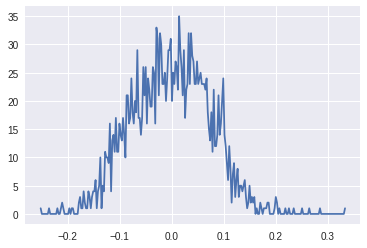

Maximum value of learnt weights: 0.27101952
Minimum value of learnt weights: -0.28948143


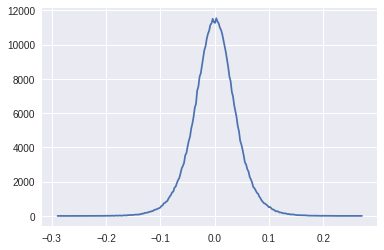

Maximum value of learnt weights: 0.16025212
Minimum value of learnt weights: -0.12405259


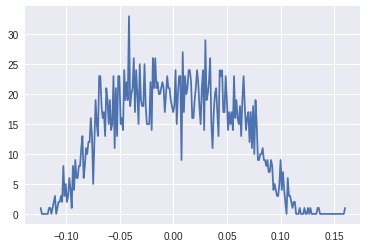

In [16]:
weightdistribution(net.state_dict()['layer2.0.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc1.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc2.weight'].cpu().numpy().flatten())

### Defining the pruning function

We use a threshold based criteria to remove certain connections in the networks which fall within a threshold value. Hence, we define a function which takes the network as input and a vlaue for threshold and forces those connections to be 0 which fall with the threshold given by the following equation.

$$
\begin{equation}
 W_{i} = 
 \begin{cases} 
      W_{i} & W_{i} < -\theta \\
      0 & -\theta\leq W_{i}\leq \theta \\
      W_{i} & \theta < W_{i} 
  \end{cases}
\end{equation}
$$

We prune both the weights and biases of Convolution layers, Fully Connected layers and the Batch Normalization layers

In [0]:
def prune_weight(net, threshold):
    
    for m in net.modules():
        if isinstance(m,nn.Conv2d) or isinstance(m,nn.BatchNorm2d) or isinstance(m,nn.Linear):

            temp_weight = m.weight.data.cpu().numpy()
            dims = temp_weight.shape
            print('WEIGHT ',dims)
            print("Before pruning------->")
            print(np.count_nonzero(temp_weight))

            temp_weight = temp_weight.flatten()

            [x1,x2]=((np.where(np.all([[(-1*threshold) < (temp_weight)] , [(temp_weight) < threshold]],axis=0))))
            temp_weight[x2] = 0
            temp_weight = np.reshape(temp_weight,dims)
            print("After pruning------->")
            print(np.count_nonzero(temp_weight))
            print('-------------------------------------------------------------------------------')
            m.weight.data = (torch.FloatTensor(temp_weight).cuda())

            temp_bias = m.bias.data.cpu().numpy()
            dims = temp_bias.shape
            print('BIAS ',dims)
            print("Before pruning------->")
            print(np.count_nonzero(temp_bias))

            temp_bias = temp_bias.flatten()

            [x1,x2]=((np.where(np.all([[(-1*threshold) < (temp_bias)] , [(temp_bias) < threshold]],axis=0))))
            temp_bias[x2] = 0
            temp_bias = np.reshape(temp_bias,dims)
            print("After pruning------->")
            print(np.count_nonzero(temp_bias))
            print('-------------------------------------------------------------------------------')
            m.bias.data = (torch.FloatTensor(temp_bias).cuda())

# for m in net.modules():
#     if isinstance(m,nn.Conv2d):
#         print m.bias.data
  

Here, we check how many connetions have been pruned

In [18]:
threshold = 0.01
prune_weight(net,threshold)

WEIGHT  (16, 1, 5, 5)
Before pruning------->
400
After pruning------->
384
-------------------------------------------------------------------------------
BIAS  (16,)
Before pruning------->
16
After pruning------->
16
-------------------------------------------------------------------------------
WEIGHT  (16,)
Before pruning------->
16
After pruning------->
16
-------------------------------------------------------------------------------
BIAS  (16,)
Before pruning------->
16
After pruning------->
16
-------------------------------------------------------------------------------
WEIGHT  (16, 16, 3, 3)
Before pruning------->
2304
After pruning------->
2075
-------------------------------------------------------------------------------
BIAS  (16,)
Before pruning------->
16
After pruning------->
14
-------------------------------------------------------------------------------
WEIGHT  (16,)
Before pruning------->
16
After pruning------->
16
------------------------------------------------

Training the network again using the regularizer. The loss is modified as 

$$
loss = loss + regularized_loss
$$

In [19]:
reset = True
use_reg = True
net = training(net, reset)
testing(net)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch: 1, Loss: 546.4263, Accuracy: 0.9532
Epoch: 2, Loss: 237.6315, Accuracy: 0.9761
Epoch: 3, Loss: 196.4055, Accuracy: 0.9782
Epoch: 4, Loss: 173.6391, Accuracy: 0.9802
Epoch: 5, Loss: 160.4983, Accuracy: 0.9815
Test Accuracy of the network on the 10000 test images: 98.53 %


<b>Visualizing the weight distributions with the regularized loss</b>

Maximum value of learnt weights: 0.08307267
Minimum value of learnt weights: -0.18182747


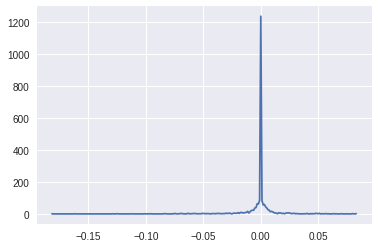

Maximum value of learnt weights: 0.41358876
Minimum value of learnt weights: -0.36285856


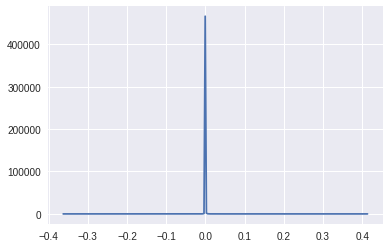

Maximum value of learnt weights: 0.73166615
Minimum value of learnt weights: -0.61624557


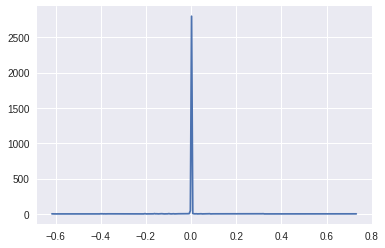

In [20]:
weightdistribution(net.state_dict()['layer2.0.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc1.weight'].cpu().numpy().flatten())
weightdistribution(net.state_dict()['fc2.weight'].cpu().numpy().flatten())

By using the L1 Regularizer, we see that we have forced the network to learn weights within a constrained subspace. Since more number of weights are closer to 0, it is evident that we will be able to make more weights 0 by using the same threshold as before. This, therefore ensures sparsity in every layer of the network.

An interesting observation is that the netowrk tells us that it does not require biases for certain layers.

In [21]:
threshold = 0.01
prune_weight(net,threshold)

WEIGHT  (16, 1, 5, 5)
Before pruning------->
400
After pruning------->
174
-------------------------------------------------------------------------------
BIAS  (16,)
Before pruning------->
16
After pruning------->
0
-------------------------------------------------------------------------------
WEIGHT  (16,)
Before pruning------->
16
After pruning------->
14
-------------------------------------------------------------------------------
BIAS  (16,)
Before pruning------->
16
After pruning------->
8
-------------------------------------------------------------------------------
WEIGHT  (16, 16, 3, 3)
Before pruning------->
2304
After pruning------->
336
-------------------------------------------------------------------------------
BIAS  (16,)
Before pruning------->
16
After pruning------->
0
-------------------------------------------------------------------------------
WEIGHT  (16,)
Before pruning------->
16
After pruning------->
11
----------------------------------------------------

### References

1. http://www.pyimagesearch.com/2016/09/19/understanding-regularization-for-image-classification-and-machine-learning/

### Please answer the questions below to complete the experiment:




In [0]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "" #@param ["Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging me", "Was Tough, but I did it", "Too Difficult for me"]


In [0]:
#@title If it was very easy, what more you would have liked to have been added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "" #@param {type:"string"}

In [0]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "" #@param ["Yes", "No"]

In [0]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id =return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")